# Pregunta 7: 
## Implementar un script Python para visualizar un mapa donde se indica el precio promedio de los anuncios por cada región, por una categoría de anuncio particular

In [95]:
import mysql.connector 

password = "password"
db_connection = mysql.connector.connect(user="root",host="localhost",password="password",  auth_plugin='mysql_native_password')
cursor = db_connection.cursor()
# cursor.execute("CREATE DATABASE Yapo_pais_trabajoSebastianDuran;") 
cursor.execute("USE Yapo_pais_trabajoSebastianDuran")

In [ ]:
cursor.execute("DROP DATABASE Yapo_pais_trabajoSebastianDuran;")

In [2]:
#tabla vendedor
cursor.execute("CREATE TABLE vendedor ("+
               "nombre VARCHAR(100) PRIMARY KEY, ciudad VARCHAR(30), codigo_region VARCHAR(3), "+
               "nombre_region VARCHAR(30), "+
               "fecha_inscripcion DATE)")

#tabla anuncio
cursor.execute("CREATE TABLE anuncio (url VARCHAR(300) PRIMARY KEY, "+
               "titulo VARCHAR(200), descripcion MEDIUMTEXT, precio VARCHAR(30), categoria VARCHAR(50), "
               +"nombre VARCHAR(100), FOREIGN KEY (nombre) REFERENCES vendedor(nombre),fecha_publicacion DATE)")

In [3]:
from urllib.request import urlopen as uReq
import urllib.request

from bs4 import BeautifulSoup as soup
from selenium import webdriver
import time
from webdriver_manager.chrome import ChromeDriverManager

In [4]:
browser = webdriver.Chrome(ChromeDriverManager().install())
myUrl = 'https://www.yapo.cl/chile?ca=15_s&o=1'
browser.get(myUrl)

[WDM] - Current google-chrome version is 84.0.4147
[WDM] - Get LATEST driver version for 84.0.4147


[WDM] - Driver [/home/sebastianduran2712/.wdm/drivers/chromedriver/linux64/84.0.4147.30/chromedriver] found in cache


In [5]:
pageSoup = soup(browser.page_source, 'html.parser')

pages = pageSoup.find('span',  {'class', 'nohistory FloatRight'}).a['href']

In [6]:
index = pages.rfind('=')
print(index)
lastPage = int(pages[index+1:])
print(lastPage)
root_pages = pages[:index+1]
print(root_pages)

35
28205
https://www.yapo.cl/chile?ca=15_s&o=


In [7]:
import datetime

def convert_date(yapo_date):
    month=yapo_date.split(" ")[0]
    year=yapo_date.split(" ")[1]
    
    convert = {'Enero' : 1,
            'Febrero' : 2,
            'Marzo' : 3,
            'Abril' : 4,
            'Mayo' : 5,
            'Junio' : 6,
            'Julio' : 7,
            'Agosto' : 8,
            'Septiembre' : 9, 
            'Octubre' : 10,
            'Noviembre' : 11,
            'Diciembre' : 12
           }
    
    
    new_date=datetime.date(int(year), convert[month], 1) 

    return new_date


def convert_date_publication(yapo_date):
    day=yapo_date.split(" ")[0]
    month=yapo_date.split(" ")[1]
    hour=yapo_date.split(" ")[2]
    
    convert = {'Enero' : 1,
            'Febrero' : 2,
            'Marzo' : 3,
            'Abril' : 4,
            'Mayo' : 5,
            'Junio' : 6,
            'Julio' : 7,
            'Agosto' : 8,
            'Septiembre' : 9, 
            'Octubre' : 10,
            'Noviembre' : 11,
            'Diciembre' : 12
           }
    
    
    new_date=datetime.date(2020, convert[month], int(day) )
    return new_date
convert_date_publication("29 Agosto 17:08")

datetime.date(2020, 8, 29)

In [9]:

for i in range(30):
    
    #recuperarmos la URL de la pagina corriente
    url = root_pages + str(i+1)
    
    #con Selenium, vamos en navegar en esta página
    browser.get(url)
    
    #empezamos el scrapping de la pagina corriente
    pageSoup = soup(browser.page_source, 'html.parser')
    
    #recuperamos todos los tags HTML que corresponden a la lista de anuncios en esta pagina
    links = pageSoup.findAll('td', {'class' : 'thumbs_subject'})
    
    #empezamos a iterar sobre cada anuncio
    for link in links:
        
        #todos los datos que necesitamos encontrar
        url, titulo, descripcion, precio, categoria="","","","",""
        nombre, ciudad, codigo_region, nombre_region, fecha_inscripcion="","","","",""
        
        #Navegamos hacia la pagina del anuncio
        url=link.find('a',{'class':'title'})['href']
        print(url)
        browser.get(link.find('a',{'class':'title'})['href'])
        
        
        #RECUPERAMOS EL TITULO DEL ANUNCIO           
        pageSoup = soup(browser.page_source, 'html.parser')
        if(pageSoup.find('h1', {"id" : "da_subject"})):
            titulo = pageSoup.find('h1', {"id" : "da_subject"}).text.strip()
            print(titulo)
            
        #RECUPERAMOS LA DESCRIPCION DEL ANUNCIO
        if(pageSoup.find('div', {"class" : "description"})):
            try:
                descripcion = pageSoup.find('div', {"class" : "description"}).text.split(' ', 1)[1].strip().replace(u'\n', u' ')
            except:
                continue
                
        #RECUPERAMOS EL PRECIO DEL ANUNCIO
        if(pageSoup.find('div', {"class" : "price text-right"})):
            precio = pageSoup.find('div', {"class" : "price text-right"}).text.strip().replace(u'\n', u' ').replace(u'\t', u'')
            print("precio:"+precio)
            
        #RECUPERAMOS LA CATEGORIA DEL ANUNCIO
        if(pageSoup.find('div', {"class" : "breadcrumbs"})):
            categoria = pageSoup.find('div', {"class" : "breadcrumbs"}).find('a', {"id" : "breadcrumb_category"}).find('strong').text.strip().replace(u'\n', u' ')
            print(categoria)
            
        #RECUPERAMOS LA FECHA DE PUBLICACIÓN DEL ANUNCIO
        if(pageSoup.find('div', {"class" : "title"})):
            fecha_publicacion_raw = pageSoup.find('div', {"class" : "title"}).find('small', {"class" : "date"}).find('time').text.strip().replace(u'\n', u' ')
            fecha_publicacion = convert_date_publication(fecha_publicacion_raw)
            print(fecha_publicacion)
        
        #RECUPERAMOS EL NOMBRE DEL VENDEDOR, SU FECHA DE INSCRIPCION Y SU LOCALIDAD
        if(pageSoup.find('aside', {"class" : "sidebar-right"})):
            aside = pageSoup.find('aside', {"class" : "sidebar-right"})
    
            #print(aside.find('seller-info'))
            
            #NOMBRE
            nombre=aside.find('seller-info').attrs['username']
            
            #FECHA DE INSCRIPCION
            fecha_inscripcion_raw=aside.find('seller-info').attrs['seniority']
            try:
                fecha_inscripcion_raw=fecha_inscripcion_raw[len("En Yapo desde "):]
                fecha_inscripcion=convert_date(fecha_inscripcion_raw)
                print(fecha_inscripcion)
            except:
                fecha_inscripcion=None
                continue
                
            #LOCALIDAD
            localidad_raw=aside.find('seller-info').attrs['region']
            
            #print(localidad_raw)
            
            #region_raw=localidad.split(",")[0]
            #ciudad_raw=localidad.split(",")[1]
            
            region_raw=localidad_raw.split(",")[0]
            ciudad_raw=localidad_raw.split(",")[1]
            
            codigo_region=region_raw.split(" ")[0]
            nombre_region=region_raw[len(codigo_region)+1:]
            ciudad=ciudad_raw[1:]
            
            print(nombre)
            print(codigo_region)
            print(nombre_region)
            print(ciudad)
         
        
        # LLENAMOS LA BASE DE DATOS: TABLA VENDEDOR
        
        try:
            sql = "INSERT INTO vendedor (nombre, ciudad, codigo_region, nombre_region, fecha_inscripcion) VALUES (%s, %s, %s,%s,%s)"
            val = (nombre, ciudad, codigo_region, nombre_region, fecha_inscripcion)
            cursor.execute(sql, val)
        except:
            continue
        
        # LLENAMOS LA BASE DE DATOS: TABLA ANUNCIO
        try:
            sql = "INSERT INTO anuncio (url, titulo, descripcion, precio, categoria,nombre,fecha_publicacion) VALUES (%s, %s, %s,%s,%s, %s, %s)"
            val = (url, titulo, descripcion, precio, categoria,nombre,fecha_publicacion)
            cursor.execute(sql, val)
        except:
            print("no ingresado")
            continue
        
        cursor.execute("COMMIT") 

https://www.yapo.cl/region_metropolitana/television_camaras/ipod_touch_4_generacion_32gb_para_arreglo_74027033.htm?ca=15_s&first=1&oa=74027033&xsp=0
Ipod touch 4 generación 32gb para arreglo
precio:$ 20.000
Audio, TV, video y fotografía
2020-08-28
2017-01-01
antonio
Región
Metropolitana
Recoleta
https://www.yapo.cl/region_metropolitana/bicicletas_ciclismo/filtro_3m_6001_74027032.htm?ca=15_s&oa=74027032&xsp=1
Filtro 3m 6001
precio:$ 5.000
Bicicletas, ciclismo y accesorios
2020-08-28
2014-07-01
solo
Región
Metropolitana
Recoleta
https://www.yapo.cl/region_metropolitana/libros_revistas/coleccion_comics___8220_the_walking_dead__8221__74027031.htm?ca=15_s&oa=74027031&xsp=2
Colección Comics “The Walking Dead”
precio:$ 70.000
Libros y revistas
2020-08-28
2018-08-01
Andrea
Región
Metropolitana
Santiago
https://www.yapo.cl/region_metropolitana/libros_revistas/revistas_escarabajo_74027030.htm?ca=15_s&oa=74027030&xsp=3
Revistas escarabajo
precio:$ 2.500
Libros y revistas
2020-08-28
2015-03-01
Ang

Cartera Lona Reciclada B/N
precio:$ 3.000
Bolsos, bisutería y accesorios
2020-08-28
2018-08-01
Andrea
Región
Metropolitana
Santiago
https://www.yapo.cl/region_metropolitana/computadores/gamer___rog_zephyrus_gx_501vk_74027000.htm?ca=15_s&oa=74027000&xsp=35
Gamer * rog zephyrus gx-501vk
precio:$ 1.100.000
Computadores y accesorios
2020-08-28
2016-05-01
Cristián Ormazábal
Región
Metropolitana
Ñuñoa
https://www.yapo.cl/biobio/autos/nissan_np_300_2017_4x4_74026999.htm?ca=9_s&oa=74026999&xsp=36
Nissan np 300 2017 4x4
precio:$ 11.100.000
Autos, camionetas y 4x4
2020-08-28
2013-11-01
Aaron
VIII
Biobío
Hualpén
https://www.yapo.cl/region_metropolitana/negocios_maquinaria_construccion/erramientas_74026998.htm?ca=15_s&oa=74026998&xsp=37
Erramientas
Negocios, maquinaria y construcción
2020-08-28
2015-04-01
Miguel romero
Región
Metropolitana
Cerro Navia
https://www.yapo.cl/region_metropolitana/celulares/celulares_a01_samsung_y_mobile_a830_74026997.htm?ca=15_s&oa=74026997&xsp=38
Celulares a01 samsung

Sustrato Organic Life 50 lts
precio:$ 8.490
Jardín, herramientas y exteriores
2020-08-28
2015-05-01
Esteban  Castillo
Región
Metropolitana
Puente Alto
https://www.yapo.cl/araucania/muebles/cama_infantil_mikey_mouse__74027067.htm?ca=10_s&oa=74027067&xsp=21
Cama infantil mikey mouse
precio:$ 60.000
Muebles
2020-08-28
2014-11-01
Alejandra 
IX
Araucanía
Temuco
https://www.yapo.cl/valparaiso/television_camaras/radio_android_original_toyota_hilux_2016_2019_74027066.htm?ca=6_s&oa=74027066&xsp=22
Radio android original Toyota hilux 2016-2019
precio:$ 400.000
Audio, TV, video y fotografía
2020-08-28
2014-02-01
claudio andres plaza peña
V
Valparaíso
San Antonio
https://www.yapo.cl/magallanes_antartica/vestuario-futura-mama-ninos/pantalon_nino_74027064.htm?ca=14_s&oa=74027064&xsp=23
Pantalón niño
precio:$ 5.000
Vestuario futura mamá y niños
2020-08-28
2015-03-01
vendedor
XII
Magallanes & Antártica
Punta Arenas
https://www.yapo.cl/region_metropolitana/negocios_maquinaria_construccion/generador_ele

Computador de escritorio marca HP con impresora
precio:$ 150.000
Computadores y accesorios
2020-08-28
2019-12-01
Diego Hernán Molina Peñailillo
VIII
Biobío
Penco
https://www.yapo.cl/region_metropolitana/arrendar/kf_metro_hospitales_cerro_blanco_74011305.htm?ca=15_s&oa=74011305&xsp=4
KF-metro hospitales/cerro blanco
precio:$ 380.000
Arriendo - Departamento
2020-08-28
2015-07-01
katherinne Flores padilla
Región
Metropolitana
Recoleta
https://www.yapo.cl/araucania/autos/ford_ecosport_2018_73975624.htm?ca=10_s&oa=73975624&xsp=5
Ford ecosport 2018
precio:$ 8.300.000
Autos, camionetas y 4x4
2020-08-28
2015-04-01
jessica sandoval
IX
Araucanía
Cholchol
https://www.yapo.cl/region_metropolitana/animales_accesorios/cachorritos_chihuahuas_inscritos_y_con_chip_73956423.htm?ca=15_s&oa=73956423&xsp=6
Cachorritos chihuahuas inscritos y con chip
precio:$ 400.000
Animales y sus accesorios
2020-08-28
2014-01-01
Mariel
Región
Metropolitana
Santiago
https://www.yapo.cl/region_metropolitana/ofertas_de_emple

Zapatillas Adidas Football
precio:$ 15.000
Calzado
2020-08-28
2020-07-01
Zulay Valecillos
Región
Metropolitana
Santiago
https://www.yapo.cl/nuble/musica_peliculas/vinilo_gazebo___telephone_mama_74027016.htm?ca=16_s&oa=74027016&xsp=39
Vinilo Gazebo - Telephone Mama
precio:$ 18.000
Música y películas (DVDs, etc.)
2020-08-28
2016-08-01
Esteban
XVI
Ñuble
Chillán
https://www.yapo.cl/region_metropolitana/animales_accesorios/caja_transportadora_dogit_voyageur_xl_74027015.htm?ca=15_s&oa=74027015&xsp=40
Caja transportadora Dogit voyageur XL
precio:$ 40.000
Animales y sus accesorios
2020-08-28
2018-08-01
Lorena Parraguez
Región
Metropolitana
Lo Espejo
https://www.yapo.cl/magallanes_antartica/computadores/necesito_ram_dd3_74027014.htm?ca=14_s&oa=74027014&xsp=41
Necesito ram dd3
precio:$ 15.000
Computadores y accesorios
2020-08-28
2019-02-01
Luis Vargas Zuñiga
XII
Magallanes & Antártica
Punta Arenas
https://www.yapo.cl/nuble/otros_vehiculos/retro_excabadora_cat_74027013.htm?ca=16_s&oa=74027013&xsp

https://www.yapo.cl/los_rios/animales_accesorios/terneros__74026986.htm?ca=11_s&oa=74026986&xsp=23
Terneros
precio:$ 750.000
Animales y sus accesorios
2020-08-28
2020-08-01
Juan
XIV
Los Ríos
Río Bueno
https://www.yapo.cl/coquimbo/negocios_maquinaria_construccion/panel_led_sobrepuesto_de_18w_luz_blanco_frio__74026985.htm?ca=5_s&oa=74026985&xsp=24
Panel led sobrepuesto de 18w luz blanco frío
Negocios, maquinaria y construcción
2020-08-28
2016-04-01
Alexandra
IV
Coquimbo
Coquimbo
https://www.yapo.cl/region_metropolitana/television_camaras/camara_instax_mini_9_74026984.htm?ca=15_s&oa=74026984&xsp=25
Cámara instax mini 9
precio:$ 55.000
Audio, TV, video y fotografía
2020-08-28
2020-08-01
Antonia Belén Herrera Villar
Región
Metropolitana
La Florida
https://www.yapo.cl/region_metropolitana/electrodomesticos/gran_ofertazo_en_aires_acondicionado__72805898.htm?ca=15_s&oa=72805898&xsp=26
Gran OFERTAZO en Aires Acondicionado
Electrodomésticos
2020-08-28
2017-06-01
Liliana Alejandra Guzman Navarro


Cómoda con 5 cajones
precio:$ 27.000
Muebles
2020-08-28
2014-08-01
Eva Espinoza
Región
Metropolitana
Providencia
https://www.yapo.cl/region_metropolitana/bolsos-bisuteria-accesorios/hermoso_crossbody_marca_victoria_secret_74026952.htm?ca=15_s&oa=74026952&xsp=8
Hermoso Crossbody marca Victoria Secret
precio:$ 39.990
Bolsos, bisutería y accesorios
2020-08-28
2020-07-01
Constanza Contreras
Región
Metropolitana
Huechuraba
https://www.yapo.cl/maule/arrendar/casa_en_un_solo_piso_3_dormitorio_curico_74026951.htm?ca=8_s&oa=74026951&xsp=9
Casa en un solo piso 3 dormitorio curico
precio:$ 330.000
Arriendo - Casa
2020-08-28
2014-09-01
Elizabeth
VII
Maule
Curicó
https://www.yapo.cl/region_metropolitana/moda-vestuario/colales_calvin_klein_74026950.htm?ca=15_s&oa=74026950&xsp=10
Colales Calvin Klein
precio:$ 11.000
Moda y vestuario
2020-08-28
2016-02-01
Betzabe Sepúlveda Arriagada 
Región
Metropolitana
Puente Alto
https://www.yapo.cl/ohiggins/negocios_maquinaria_construccion/pistola_para_pintar___nu

xbox one s 1tb
Consolas, videojuegos y accesorios
2020-08-28
2017-09-01
Angel
XII
Magallanes & Antártica
Punta Arenas
https://www.yapo.cl/coquimbo/muebles/living_usado__74026919.htm?ca=5_s&oa=74026919&xsp=43
living usado
Muebles
2020-08-28
2015-01-01
Joselyn 
IV
Coquimbo
Coquimbo
https://www.yapo.cl/region_metropolitana/celulares/excelentes_samsung_ear_buds_74026918.htm?ca=15_s&oa=74026918&xsp=44
Excelentes Samsung Ear Buds
precio:$ 80.000
Celulares, teléfonos y accesorios
2020-08-28
2015-08-01
JUAN CLAUDIO LEGARRETA
Región
Metropolitana
Providencia
https://www.yapo.cl/coquimbo/juguetes/muneca_en_bicicleta_evi_love_74026917.htm?ca=5_s&oa=74026917&xsp=45
Muñeca en bicicleta evi love
precio:$ 4.990
Juguetes
2020-08-28
2016-10-01
Pamela
IV
Coquimbo
La Serena
https://www.yapo.cl/region_metropolitana/moda-vestuario/bralet_calvin_klein_74026916.htm?ca=15_s&oa=74026916&xsp=46
Bralet Calvin Klein
precio:$ 22.000
Moda y vestuario
2020-08-28
2016-02-01
Betzabe Sepúlveda Arriagada 
Región
Metropo

Receiver Sony
precio:$ 45.000
Audio, TV, video y fotografía
2020-08-28
2013-11-01
souza
Región
Metropolitana
Santiago
https://www.yapo.cl/valparaiso/computadores/cpu_cooler_74026885.htm?ca=6_s&oa=74026885&xsp=29
Cpu cooler
precio:$ 30.000
Computadores y accesorios
2020-08-28
2014-09-01
Matias marchant
V
Valparaíso
Calera
https://www.yapo.cl/ohiggins/motos/busco__honda_crf_100cc_y_150cc_74026884.htm?ca=7_s&oa=74026884&xsp=30
Busco: Honda crf 100cc y 150cc
precio:$ 88.880
Motos
2020-08-28
2014-06-01
luis
VI
O'Higgins
Rancagua
https://www.yapo.cl/los_rios/arrendar/cabana_amoblada_en_las_animas_74026883.htm?ca=11_s&oa=74026883&xsp=31
Cabaña amoblada en Las Animas
precio:$ 180.000
Arriendo - Casa
2020-08-28
2020-07-01
M V. Corretaje y administración
XIV
Los Ríos
Valdivia
https://www.yapo.cl/region_metropolitana/autos/chevrolet_spark_2013_74026882.htm?ca=15_s&oa=74026882&xsp=32
Chevrolet spark 2013
precio:$ 1.600.000
Autos, camionetas y 4x4
2020-08-28
2020-04-01
Tattersall Remates
Región
Met

departamento EL Llano
precio:$ 57.000.000
Vendo - Departamento
2020-08-28
2016-07-01
Angelica Urzua Lucke
Región
Metropolitana
San Miguel
https://www.yapo.cl/maule/electrodomesticos/horno_electeico_73927283.htm?ca=8_s&oa=73927283&xsp=14
Horno elécteico
precio:$ 65.000
Electrodomésticos
2020-08-28
2017-11-01
Ana Janet Lagos C
VII
Maule
Talca
https://www.yapo.cl/ohiggins/autos/hyundai_santa_fe_74026848.htm?ca=7_s&oa=74026848&xsp=15
Hyundai santa fe
Autos, camionetas y 4x4
2020-08-28
2015-07-01
maria martinez villagra
VI
O'Higgins
Pumanque
https://www.yapo.cl/region_metropolitana/accesorios_vehiculos/tapabarro_copiloto_l200_2006_2015_74026847.htm?ca=15_s&oa=74026847&xsp=16
Tapabarro copiloto L200 2006-2015
precio:$ 35.000
Accesorios y piezas para vehículos
2020-08-28
2014-11-01
cristian
Región
Metropolitana
Lampa
https://www.yapo.cl/region_metropolitana/autos/nissan_juke_2014_74026846.htm?ca=15_s&oa=74026846&xsp=17
Nissan juke 2014
precio:$ 7.600.000
Autos, camionetas y 4x4
2020-08-28
201

Tucson 2010 automático
precio:$ 7.500.000
Autos, camionetas y 4x4
2020-08-28
2015-12-01
Cristian
VIII
Biobío
Los Ángeles
https://www.yapo.cl/maule/arrendar/casa_3_dormitorios_2_banos_maule__talca_74026814.htm?ca=8_s&oa=74026814&xsp=49
Casa 3 Dormitorios 2 Baños Maule, Talca
precio:$ 270.000
Arriendo - Casa
2020-08-28
2014-05-01
Paz Fernandez
VII
Maule
Talca
https://www.yapo.cl/region_metropolitana/arte_antiguedades_colecciones/funko_pop_black_panther_74026813.htm?ca=15_s&oa=74026813&xsp=0
Funko pop Black Panther
precio:$ 70.000
Arte, antigüedades y colecciones
2020-08-28
2014-07-01
paula
Región
Metropolitana
Puente Alto
https://www.yapo.cl/biobio/autos/peugeot_301_74026812.htm?ca=9_s&oa=74026812&xsp=1
Peugeot 301
precio:$ 7.500.000
Autos, camionetas y 4x4
2020-08-28
2014-07-01
valeska rodriguez sanchez
VIII
Biobío
Talcahuano
https://www.yapo.cl/magallanes_antartica/autos/auto_74026811.htm?ca=14_s&oa=74026811&xsp=2
Auto
precio:$ 2.300.000
Autos, camionetas y 4x4
2020-08-28
2018-06-01
Da

Busco casa en Santiago
precio:$ 350.000
Arriendo - Casa
2020-08-28
2018-11-01
Zaida Corro
Región
Metropolitana
Santiago
https://www.yapo.cl/valparaiso/autos/toyota_corolla_2008_73897039.htm?ca=6_s&oa=73897039&xsp=34
Toyota corolla 2008
precio:$ 3.600.000
Autos, camionetas y 4x4
2020-08-28
https://www.yapo.cl/biobio/servicios/camiones_nuevos_para_mudanzas_73895613.htm?ca=9_s&oa=73895613&xsp=35
Camiones nuevos para mudanzas
Servicios
2020-08-28
2020-08-01
Felipe hernan 
VIII
Biobío
Concepción
https://www.yapo.cl/region_metropolitana/ofertas_de_empleo/se_solicita_cajero_con_experiencia_73993230.htm?ca=15_s&oa=73993230&xsp=36
Se solicita cajero con experiencia
precio:$ 15.000
Ofertas de empleo
2020-08-28
2016-11-01
Yessica Carolina Duque Bastida
Región
Metropolitana
Providencia
https://www.yapo.cl/magallanes_antartica/autos/toyota_yaris_hb_2017_73974950.htm?ca=14_s&oa=73974950&xsp=37
Toyota yaris hb 2017
precio:$ 7.500.000
Autos, camionetas y 4x4
2020-08-28
2016-08-01
César
XII
Magallanes 

Pateador e hilerador
precio:$ 550.000
Negocios, maquinaria y construcción
2020-08-28
2016-04-01
Alejo
X
Los Lagos
Río Negro
https://www.yapo.cl/nuble/autos/camioneta_74026773.htm?ca=16_s&oa=74026773&xsp=19
camioneta
precio:$ 800.000
Autos, camionetas y 4x4
2020-08-28
2020-08-01
Jorge
XVI
Ñuble
Quillón
https://www.yapo.cl/region_metropolitana/muebles/cama_cuja_rosen_74026772.htm?ca=15_s&oa=74026772&xsp=20
Cama cuja Rosen
Muebles
2020-08-28
2016-02-01
Fabiola
Región
Metropolitana
Maipú
https://www.yapo.cl/region_metropolitana/muebles/cama_de_madera_nueva_de_dos_plazas_74026771.htm?ca=15_s&oa=74026771&xsp=21
Cama de madera nueva de dos plazas
precio:$ 150.000
Muebles
2020-08-28
2016-01-01
Daniela Carrillo
Región
Metropolitana
Santiago
https://www.yapo.cl/region_metropolitana/autos/pegueot_307_full_74026077.htm?ca=15_s&oa=74026077&xsp=22
Pegueot 307 full
precio:$ 2.700.000
Autos, camionetas y 4x4
2020-08-28
2019-06-01
Pablo ovalle
Región
Metropolitana
Pudahuel
https://www.yapo.cl/araucania

TV 55" quebrada
precio:$ 70.000
Audio, TV, video y fotografía
2020-08-28
2017-01-01
Eduardo Campos
VII
Maule
Talca
https://www.yapo.cl/maule/celulares/samsung_galaxy_gear_s3_frontier_74026739.htm?ca=8_s&oa=74026739&xsp=5
Samsung galaxy gear s3 frontier
precio:$ 140.000
Celulares, teléfonos y accesorios
2020-08-28
2014-04-01
luis jose Dieguez
VII
Maule
Talca
https://www.yapo.cl/region_metropolitana/accesorios_vehiculos/bandejas_partner_berlingo_2013_2018_74026738.htm?ca=15_s&oa=74026738&xsp=6
Bandejas partner berlingo 2013-2018
precio:$ 60.000
Accesorios y piezas para vehículos
2020-08-28
2014-11-01
cristian
Región
Metropolitana
Lampa
https://www.yapo.cl/region_metropolitana/bolsos-bisuteria-accesorios/bolso_xtreme_girl_74026737.htm?ca=15_s&oa=74026737&xsp=7
Bolso Xtreme girl
precio:$ 15.000
Bolsos, bisutería y accesorios
2020-08-28
2017-09-01
Francisca O
Región
Metropolitana
Las Condes
https://www.yapo.cl/region_metropolitana/autos/busco__citroen_bx_solo_buen_estado_74026735.htm?ca=15_

Peugeot 206 Xs 2003 FullEquipo Sport Hatchback 1.6
precio:$ 2.390.000
Autos, camionetas y 4x4
2020-08-28
2015-04-01
Ignacio
V
Valparaíso
Villa Alemana
https://www.yapo.cl/region_metropolitana/comprar/linda_parcela_de_agrado_con_vegetacion_na_74026705.htm?ca=15_s&oa=74026705&xsp=40
Linda parcela de agrado con vegetación na
precio:UF 1.500,00
Vendo - Terreno
2020-08-28
2017-10-01
Catalina
Región
Metropolitana
Vitacura
https://www.yapo.cl/antofagasta/arrendar/residencial_sector_sur_13h_6b__74026704.htm?ca=3_s&oa=74026704&xsp=41
Residencial sector sur 13H/6B;
precio:$ 3.000.000
Arriendo - Casa
2020-08-28
2020-08-01
k&c propiedades
II
Antofagasta
Antofagasta
https://www.yapo.cl/maule/celulares/cargador_huawei_tipo_c_74026703.htm?ca=8_s&oa=74026703&xsp=42
Cargador Huawei Tipo C
precio:$ 7.990
Celulares, teléfonos y accesorios
2020-08-28
2017-11-01
Karin Bravo
VII
Maule
Talca
https://www.yapo.cl/magallanes_antartica/moda-vestuario/poleron_talla_l_74026702.htm?ca=14_s&oa=74026702&xsp=43
Polero

In [2]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas import DataFrame
import pandas as pd

sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(12,6))

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [5]:
shp_path = "./cl_regiones_geo/cl_regiones_geo.shp"
sf = shp.Reader(shp_path, encoding="ISO8859-1")

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df


df = read_shapefile(sf)
df.shape

(15, 3)

In [61]:
from pandas import DataFrame
#¿Cuál es el número de anuncios Yapo.cl en cada región de Chile ?

sql = "select nombre_region, count(*) as nb_anuncios from vendedor join anuncio using (nombre) where nombre_region != \"Ñuble\" and  categoria = \"Arriendo - Departamento\" group by nombre_region order by nb_anuncios DESC;"
cursor.execute(sql)
df1 = DataFrame(cursor.fetchall())
df1.columns = cursor.column_names
df1

,nombre_region,nb_anuncios
0,Valparaíso,3
1,Tarapacá,2
2,Los Ríos,1


In [62]:
df1.loc[df1.nombre_region == "Metropolitana", "nombre_region"] = "Metropolitana de Santiago"
df1.loc[df1.nombre_region == "Valparaíso", "nombre_region"] = "Valparaiso"
df1.loc[df1.nombre_region == "Biobío", "nombre_region"] = "Biobio"
df1.loc[df1.nombre_region == "Magallanes & Antártica", "nombre_region"] = "Magallanes y de la Antartica Chileno"
df1.loc[df1.nombre_region == "Araucanía", "nombre_region"] = "La Araucania"
df1.loc[df1.nombre_region == "O'Higgins", "nombre_region"] = "Libertador Gral. Bernardo O'Higgins"
df1.loc[df1.nombre_region == "Los Ríos", "nombre_region"] = "Los Rios"
df1.loc[df1.nombre_region == "Tarapacá", "nombre_region"] = "Tarapaca"
df1.loc[df1.nombre_region == "Aisén", "nombre_region"] = "Aisen del Gral. Carlos Ibañez del Campo"
df1.loc[df1.nombre_region == "Arica & Parinacota", "nombre_region"] = "Arica y Parinacota"

In [23]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [24]:
def calc_color(data, color=None):
        if color   == 1: 
            color_sq =  ['#dadaebFF','#bcbddcF0','#9e9ac8F0',
                        '#807dbaF0','#6a51a3F0','#54278fF0']; 
            colors = 'Purples';
        elif color == 2: 
            color_sq = ['#c7e9b4','#7fcdbb','#41b6c4',
                        '#1d91c0','#225ea8','#253494']; 
            colors = 'YlGnBu';
        elif color == 3: 
            color_sq = ['#f7f7f7','#d9d9d9','#bdbdbd',
                        '#969696','#636363','#252525']; 
            colors = 'Greys';
        elif color == 9: 
            color_sq = ['#ff0000','#ff0000','#ff0000',
                        '#ff0000','#ff0000','#ff0000']
        else:            
            color_sq = ['#ffffd4','#fee391','#fec44f',
                        '#fe9929','#d95f0e','#993404']; 
            colors = 'YlOrBr';
        
        new_data, bins = pd.qcut(data, 6, retbins=True, labels=list(range(6)))
        color_ton = []
        for val in new_data:
            color_ton.append(color_sq[val]) 
        if color != 9:
            colors = sns.color_palette(colors, n_colors=6)
            sns.palplot(colors, 0.6);
            for i in range(6):
                print ("\n"+str(i+1)+': '+str(int(bins[i]))+
                       " => "+str(int(bins[i+1])-1), end =" ")
            print("\n\n   1   2   3   4   5   6")    
        return color_ton, bins;

In [25]:
def plot_regiones_data(sf, title, regiones, data=None, 
                      color=None, print_id=False):
    '''
    Plot map with selected comunes, using specific color
    '''
    
    color_ton, bins = calc_color(data, color)
    df = read_shapefile(sf)
    region_id = []
    for i in regiones:
        print(df[df.NOMBRE == i].index)
        id = df[df.NOMBRE == i].index[0]
        print(id)
        region_id.append(id)
        
        
    y_lim = (-41,-17) # latitude 
    x_lim = (-76, -66) # longitude
    
    plot_map_fill_multiples_ids_tone(sf, title, region_id, 
                                     print_id, 
                                     color_ton, 
                                     bins, 
                                     x_lim = x_lim, 
                                     y_lim = y_lim, 
                                     figsize = (10,25));

In [26]:
def plot_map_fill_multiples_ids_tone(sf, title, comuna,  
                                     print_id, color_ton, 
                                     bins, 
                                     x_lim = None, 
                                     y_lim = None, 
                                     figsize = (5,12)):
    '''
    Plot map with lim coordinates
    '''
        
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
            
    for id in comuna:
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        ax.fill(x_lon,y_lat, color_ton[comuna.index(id)])
        if print_id != False:
            x0 = np.mean(x_lon)
            y0 = np.mean(y_lat)
            plt.text(x0, y0, id, fontsize=10)
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)


1: 1 => 0 
2: 1 => 0 
3: 1 => 1 
4: 2 => 1 
5: 2 => 1 
6: 2 => 2 

   1   2   3   4   5   6
Int64Index([5], dtype='int64')
5
Int64Index([1], dtype='int64')
1
Int64Index([11], dtype='int64')
11


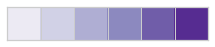

<Figure size 720x1800 with 0 Axes>

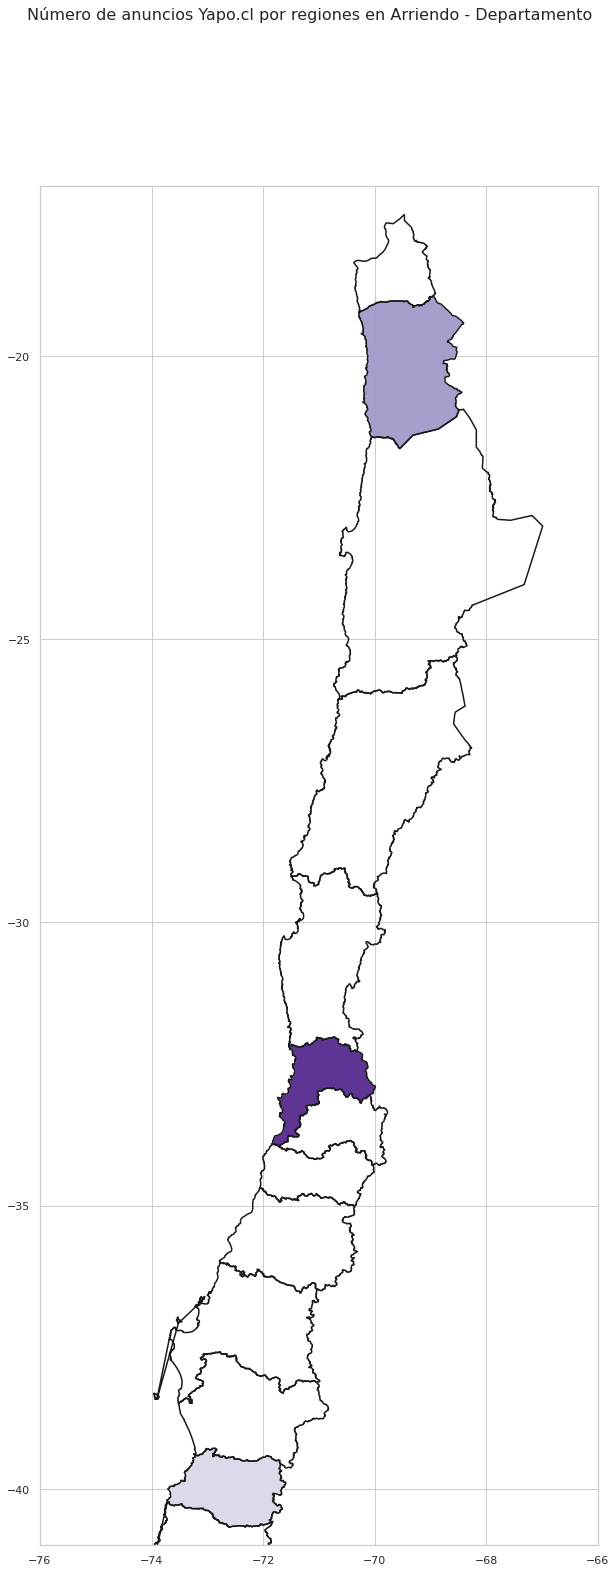

In [28]:
data = df1.nb_anuncios
regiones = df1.nombre_region

print_id = False # The shape id will be printed
color_pallete = 1 # 'Purples'
plot_regiones_data(sf, 'Número de anuncios Yapo.cl por regiones en Arriendo - Departamento', regiones, data, color_pallete, print_id)

In [27]:
pd.options.display.max_colwidth = 300
sql = "select url,titulo,precio from anuncio where categoria = \"Arriendo - Departamento\" order by precio DESC;"
cursor.execute(sql)
df1 = DataFrame(cursor.fetchall())
df1.columns = cursor.column_names
df1

,url,titulo,precio
0,https://www.yapo.cl/tarapaca/arrendar/3_oficinas_2_banos__pasaje_alessandri_74026765.htm?ca=2_s&oa=74026765&xsp=17,"3 Oficinas 2 Baños, Pasaje Alessandri",$ 500.000
1,https://www.yapo.cl/valparaiso/arrendar/cozy__full_amoblado__central__bello_dtpto__73805201.htm?ca=6_s&oa=73805201&xsp=3,"COZY, FULL AMOBLADO, Central, BELLO dtpto",$ 410.000
2,https://www.yapo.cl/valparaiso/arrendar/depto_viana_73955972.htm?ca=6_s&oa=73955972&xsp=28,depto Viana,$ 410.000
3,https://www.yapo.cl/los_rios/arrendar/departamento_full_equipado__74027076.htm?ca=11_s&oa=74027076&xsp=13,departamento full equipado,$ 380.000
4,https://www.yapo.cl/valparaiso/arrendar/depto_amoblado_placeres_cerca_usm_incluye_gastos_c_73457657.htm?ca=6_s&oa=73457657&xsp=46,Depto amoblado Placeres cerca USM incluye gastos C,$ 360.000
5,https://www.yapo.cl/tarapaca/arrendar/departamento__74026805.htm?ca=2_s&oa=74026805&xsp=47,departamento,$ 290.000


# Pregunta 8: 
## Implementar un script Python para mostrar las 10 palabras claves (“más frecuentes”) de cada categoría de anuncios.

In [28]:
sql = "select titulo from anuncio;"
cursor.execute(sql)
titulos = cursor.fetchall()

In [41]:
titulosUnidos = ""
for i in titulos:
        titulosUnidos += i[0]

listaPalabras = titulosUnidos.split()

frecuenciaPalab = []
for w in listaPalabras:
    frecuenciaPalab.append(listaPalabras.count(w))
#print("Pares\n" + str(list(zip(listaPalabras, frecuenciaPalab))))

In [53]:
frecuencias = list(zip(listaPalabras, frecuenciaPalab))
frec = []
for i in frecuencias:
    if not i in frec:
        frec.append(i)
frec

[('o', 2),
 ('permutoBusco', 1),
 ('colchon', 1),
 ('de', 30),
 ('2', 4),
 ('plazasvidrio', 1),
 ('templado', 1),
 ('para', 8),
 ('showerPeugeot', 1),
 ('207', 1),
 ('Diésel', 1),
 ('20', 2),
 ('kms', 1),
 ('x', 2),
 ('ltsBallerina', 1),
 ('zapatosCelular', 1),
 ('en', 13),
 ('perfectas', 1),
 ('condicionescasa', 1),
 ('grandeSin', 1),
 ('comisión', 1),
 (',casa', 1),
 ('central,', 1),
 ('ideal', 1),
 ('inversiónRadios', 1),
 ('transmisorasModem', 1),
 ('internet', 1),
 ('wi', 1),
 ('fiCamion', 1),
 ('tonka', 1),
 ('a', 4),
 ('bateriaCAMISA', 1),
 ('Varonil', 1),
 ('NuevaJens', 1),
 ('elasticadoscama', 1),
 ('perfecto', 1),
 ('estadoEscritorio', 1),
 ('vidrioPila', 1),
 ('CR', 1),
 ('2016Traslado', 1),
 ('empresasMiniComponente', 1),
 ('sonyCascos', 1),
 ('con', 7),
 ('intercomunicadorDefensa', 1),
 ('camionetaCorneroPerro', 1),
 ('macho', 1),
 ('y', 6),
 ('perrita', 1),
 ('hermbraBuscamos', 1),
 ('casaToma', 1),
 ('CortinasAuto', 1),
 ('hyundai', 1),
 ('accentBusco:', 1),
 ('AutoFiat'

In [54]:
def burbuja(A):
    for i in range(1,len(A)):
        for j in range(0,len(A)-i):
            if(A[j-1][1]< A[j][1]):
                aux=A[j];
                A[j]=A[j-1];
                A[j-1]=aux;
    return A
A = burbuja(frec)

In [59]:
F = ['de','para', 'en', 'con','y','o','a','-']
for i in range(10000):
    F.append(str(i))
i = 0
j = 0
while j < 10:
    if not A[i][0] in F:
        print(A[i])
        j+=1
    i+=1

('casa', 4)
('luz', 3)
('talla', 3)
('x', 2)
('busca', 2)
('bicicleta', 2)
('buen', 2)
('led', 2)
('color', 2)
('2016-2019', 1)


# Pregunta 9: 
## Implementar un script Python para mostrar la palabra clave (“más frecuente”) por cada región

In [83]:
sql = "select nombre_region, titulo from anuncio join vendedor using (nombre) where nombre_region != \"Ñuble\" "
cursor.execute(sql)
df2 = DataFrame(cursor.fetchall())
df2.columns = cursor.column_names
df2

,nombre_region,titulo
0,Arica & Parinacota,Busco: Scooter
1,Los Lagos,Suzuki sx4 2011
2,Valparaíso,Trotadora
3,Los Ríos,Horno ahumador
4,Antofagasta,Traslado a empresas
...,...,...
187,Los Ríos,Compro patos mudos
188,Araucanía,Parka Helly Hansen Mujer
189,Tarapacá,Juegos PS4
190,Los Ríos,Maestro carpintero responsable


In [102]:
sql = "select nombre_region, count(*) as nb_anuncios from vendedor join anuncio using (nombre) where nombre_region != \"Ñuble\" group by nombre_region order by nb_anuncios DESC;"
cursor.execute(sql)
df1 = DataFrame(cursor.fetchall())
df1.columns = cursor.column_names
df1["nombre_region"]
#df1.loc[df1.nombre_region == "Metropolitana", "nombre_region"] = "Metropolitana de Santiago"
#df1.loc[df1.nombre_region == "Valparaíso", "nombre_region"] = "Valparaiso"
#df1.loc[df1.nombre_region == "Biobío", "nombre_region"] = "Biobio"
#df1.loc[df1.nombre_region == "Magallanes & Antártica", "nombre_region"] = "Magallanes y de la Antartica Chileno"
#df1.loc[df1.nombre_region == "Araucanía", "nombre_region"] = "La Araucania"
#df1.loc[df1.nombre_region == "O'Higgins", "nombre_region"] = "Libertador Gral. Bernardo O'Higgins"
#df1.loc[df1.nombre_region == "Los Ríos", "nombre_region"] = "Los Rios"
#df1.loc[df1.nombre_region == "Tarapacá", "nombre_region"] = "Tarapaca"
#df1.loc[df1.nombre_region == "Aisén", "nombre_region"] = "Aisen del Gral. Carlos Ibañez del Campo"
#df1.loc[df1.nombre_region == "Arica & Parinacota", "nombre_region"] = "Arica y Parinacota"

0                 Valparaíso
1                  Araucanía
2                   Los Ríos
3                  Los Lagos
4                   Coquimbo
5                  O'Higgins
6                Antofagasta
7                      Maule
8     Magallanes & Antártica
9                   Tarapacá
10        Arica & Parinacota
11                     Aisén
12                   Atacama
Name: nombre_region, dtype: object

In [124]:
sql = "select nombre_region, titulo from anuncio join vendedor using (nombre) where nombre_region != \"Ñuble\""
cursor.execute(sql)
titulos = cursor.fetchall()
for i in df1.nombre_region:
    titulosUnidos = ""
    for j in titulos:
        if j[0] == i:
            titulosUnidos += j[1]
    
    listaPalabras = titulosUnidos.split()
    
    frecuenciaPalab = []
    for w in listaPalabras:
         frecuenciaPalab.append(listaPalabras.count(w))
            
    frecuencias = list(zip(listaPalabras, frecuenciaPalab))
    frec = []
    for m in frecuencias:
        if not m in frec:
            frec.append(m)
    A = burbuja(frec)
    F = ['de','para', 'en', 'con','y','o','a','-']
    for l in range(10000):
         F.append(str(l))
    k = 0
    z = 0
    while z < 1:
        if not A[k][0] in F:
            print(i, " :")
            print(A[k][0])
            print(" ")
            z+=1
        k+=1
    #print(frecuenciaPalab)

Valparaíso  :
casa
 
Araucanía  :
Mujer
 
Los Ríos  :
terreno
 
Los Lagos  :
malmol
 
Coquimbo  :
luz
 
O'Higgins  :
seguridad
 
Antofagasta  :
grande
 
Maule  :
Talca
 
Magallanes & Antártica  :
xbox
 
Tarapacá  :
PS4
 
Arica & Parinacota  :
Busco:
 
Aisén  :
permutoBusco
 
Atacama  :
Busco
 


# Pregunta 10: 
## A partir de los datos disponibles en Yapo.cl, ¿qué escenario de análisis pueden proponer para analizar la actividad económica en Chile durante el periodo de Covid? 

### Los datos en que se pueden analizar la actividad económica de Chile durante el periodo del covid, son:
### 1- La cantidad de publicaciones que se hace por semana, para saber el comportamiento de la oferta  y demanda en realción a la cantidad de trabajo disponible, que por el covid claramente disminuyo.
### 2- Ver como fueron afectadas los precios de las casas/sitios, a raiz de que el arriendo bajo y el cambio de casa en muchos casos se tuvieron que posponer. 